In [1]:
import re
import csv
import pandas as pd
import numpy as np
import pickle
import time
import string
import os
os.chdir("C:/Datasets/Amazon/")
import gc
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from nltk.corpus import stopwords

import eli5
from collections import Counter

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, log_loss, accuracy_score, mean_squared_log_error
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from lightgbm import LGBMClassifier

import tensorflow as tf
from keras import backend as K

from keras.preprocessing import text, sequence
from keras import optimizers
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
def combine_CSVs_infolder():
    """
    Concatenate all the review data under one csv.
    """
    os.chdir(r"..\comments_AMAZON")
    filenames = os.listdir()
    comb = pd.concat( [pd.read_csv(f) for f in filenames])
    comb.to_csv('AMAZON_comments_yuge.csv', index=False)

def clean_str(text):
    """
    Leave only workable text data.
    """
    try:
        text = ' '.join( [w for w in text.split()] )        
        text = text.lower()
        text = re.sub(u"é", u"e", text)
        text = re.sub(u"ē", u"e", text)
        text = re.sub(u"è", u"e", text)
        text = re.sub(u"ê", u"e", text)
        text = re.sub(u"à", u"a", text)
        text = re.sub(u"â", u"a", text)
        text = re.sub(u"ô", u"o", text)
        text = re.sub(u"ō", u"o", text)
        text = re.sub(u"ü", u"u", text)
        text = re.sub(u"ï", u"i", text)
        text = re.sub(u"ç", u"c", text)
        text = re.sub(u"\u2019", u"'", text)
        text = re.sub(u"\xed", u"i", text)
        text = re.sub(u"w\/", u" with ", text)
        
        text = re.sub(u"[^a-z0-9]", " ", text)
        text = re.sub(r'\d+', '', text)
        text = re.sub( u"\s+", u" ", text ).strip()
        text = ''.join(text)
    except:
        text = np.NaN
    return text

def sorttext(x):
    """
    Select only the user review from text data.
    """
    iscolor = x[3][:5]=='Color'
    isprovider = x[3][:17]=='Service Provider:'
    issize = x[3][:5]=='Size:'
    isstyle = x[3][:6]=='Style:'
    
    if iscolor | isprovider | issize:
        if 'helpful' in x[-3]:
            x = " ".join(x[4:-3])
        else:
            x = " ".join(x[4:-2])
    else:
        if 'helpful' in x[-3]:
            x = " ".join(x[4:-3])
        else:
            x = " ".join(x[4:-2])
    return x

def goBar(variables,name,text=None):
    """ Plotly Bar Plot """
    trace= go.Bar(
            x=variables.index,
            y=variables.values,
            text=text,
            textposition='auto',
            marker=dict(
                color=list(range(len(variables)))
                ),
            )
    layout = go.Layout(
        title = name
        )

    data = [trace]
    fig = go.Figure(
                    data=data,
                    layout=layout
                   )
    py.iplot(fig)

def plot_learning_curve(estimator, title, X, y, scoring=None, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    estimator:  model
    title: Graph title
    X: train data
    y: test data
    scoring: accuracy, neg_log_loss, etc.
    ylim: y limit
    cv: split (takes integer)
    """
    plt.figure()
    plt.subplots(figsize=(12,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv, n_jobs=n_jobs,
                                                            scoring=scoring,
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig('learningcurves.png')
    return plt

def model_eval(model, X, y, k=5, seed=0):
    kfold = StratifiedKFold(k, shuffle=True,random_state=seed)
    oof = np.zeros(y.shape[0])
    for nfold, (train_ix, valid_ix) in enumerate(kfold.split(X,y)):
        trainX, validX = X[train_ix], X[valid_ix]
        trainy, validy = y[train_ix], y[valid_ix]
        
        model.fit(trainX, trainy)
        p = model.predict(validX)
        oof[valid_ix] = p
        print('Fold{}, Accuracy : {:.2%}'.format(nfold+1, accuracy_score(validy, p)))
        print('Log Loss: {:.2f}'.format(log_loss(validy, p)))
    print(confusion_matrix(y, oof))
    print(classification_report(y, oof, target_names=["1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"]))
    print("Accuracy : {:.2%}".format(accuracy_score(y, p)))
    print("Log Loss: {:.2f}".format(log_loss(y, p)))
    return model, oof

def simple_eval(model, X, y, val_X):
    model.fit(X, y)
    p = model.predict(val_X)
    prob = model.predict_proba(val_X)
    print(classification_report(test_y, p, target_names=["1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"]))
    print("F1_micro/Acc : {:.2%} ".format(f1_score(test_y, p, average='micro')))
    print('Log Loss: {:.2f}'.format(log_loss(test_y, prob, labels=[1,2,3,4,5])))
    return model, prob

def pickle_model(model, filename):
    MODEL_PATH = "C:/Datasets/model_save/"
    pickle.dump(model, open(MODEL_PATH+filename, 'wb'))

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [3]:
df = pd.read_csv('AMAZON_comments_yuge.csv')
df = df.drop_duplicates(subset='Text', keep=False)
df.reset_index(inplace=True,drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199672 entries, 0 to 199671
Data columns (total 3 columns):
Text           199672 non-null object
Phone Title    199672 non-null object
Stars          199672 non-null int64
dtypes: int64(1), object(2)
memory usage: 4.6+ MB
None


In [4]:
df['Text'][18]

"xena\r\r\nWould buy again 😊\r\r\nSeptember 28, 2017\r\r\nColor: GoldVerified Purchase\r\r\nIt works really well a couple times it turned off and tried to reboot itelf. It could've just been like updating I'm not sure, this is my first iPhone but other than that it works really well. It rebooted one more time but it hasn't done it again. There were no scratches or anything. It looks really nice and everything works so far. The seller even emailed me and said if I wasn't 100% satisfied to contact them. I am very happy with the phone and it even worked with Straight Talk.\r\r\n2 people found this helpful\r\r\nHelpful\r\r\n1 comment Report abuse"

In [5]:
df['Text'][18].split('\r\r\n')

['xena',
 'Would buy again 😊',
 'September 28, 2017',
 'Color: GoldVerified Purchase',
 "It works really well a couple times it turned off and tried to reboot itelf. It could've just been like updating I'm not sure, this is my first iPhone but other than that it works really well. It rebooted one more time but it hasn't done it again. There were no scratches or anything. It looks really nice and everything works so far. The seller even emailed me and said if I wasn't 100% satisfied to contact them. I am very happy with the phone and it even worked with Straight Talk.",
 '2 people found this helpful',
 'Helpful',
 '1 comment Report abuse']

In [6]:
df['Text'] = df['Text'].apply(lambda x: x.split('\r\r\n'))  # Seperate text into parts
df['Name'] = df['Text'].apply(lambda x: x[0])  # Name of the commentator
df['Title'] = df['Text'].apply(lambda x: x[1])
df['Text'] = df['Text'].apply(sorttext)

## Gender Ratio

In [7]:
"""
https://github.com/MatthiasWinkelmann/firstname-database

F female
1F female if first part of name, otherwise mostly male
?F mostly female
M male
1M male if first part of name, otherwise mostly female
?M mostly male
? unisex
"""
gnames = pd.read_csv("firstnames.csv",sep=';', usecols=['name', 'gender'])

gnames.dropna(axis=0,inplace=True)

gnames['name'] = gnames['name'].apply(lambda x: x.lower())
gnames.columns = ['fname', 'gender']

gnames.drop_duplicates(subset=['fname'],inplace=True)

gnames.gender = gnames.gender.apply(
    lambda x: 'F' if 'F' in x else ('M' if 'M' in x else ('U' if x=='?' else '???'))
                                   )

df['fname'] = df['Name'].apply(lambda x: x.lower() if len(x.split())<2 else x.split()[0].lower())  # Leave the first name (for the most cases)

df = pd.merge(df, gnames, how='left', on='fname')

gg = df['gender'].value_counts()
#M : 56%
#F : 42%
#U : 2%

In [8]:
goBar(gg,'Gender Bar',text=['56%','42%','2%'])

In [9]:
# Gather phone model names from the data
modellist = list(set(df['Phone Title'].values))
modellist = list(map(lambda model: ''.join([e for e in model if e not in set(string.punctuation)]),modellist))
brands = []
models_1 = []
models_2 = []
for model in modellist:
    if len(model.split())>3:
        brand = model.split()[0]
        brands.append(brand)

        m = model.split()[1]
        models_1.append(m)

        m = model.split()[2]
        models_2.append(m)
    else:pass
models_1 = set(map(lambda x: x.lower().strip(),set(models_1)))
models_2 = set(map(lambda x: x.lower().strip(),set(models_2)))
models = list(models_1.union(models_2))# Merge the two models set, because they contain some duplicate names.
brands = list(map(lambda x: x.lower().strip(),set(brands)))

In [10]:
df.isna().any()

Text           False
Phone Title    False
Stars          False
Name           False
Title          False
fname          False
gender          True
dtype: bool

In [11]:
t0 = time.time()
print("Preprocessing Comments..","\n")

print('# Make everything lowercase for the simplicity.')
df['Text'] = df['Text'].apply(lambda x: x.lower())
df['Title'] = df['Title'].apply(lambda x: x.lower())

# Titles contain the summary information of customer reviews, titles should be added into Text column but some contain Target info.
df['Title'] = df['Title'].apply(lambda x: "" if ('star' in x.split())|('stars' in x.split()) else x)

print('# Merge Comments and Titles')
df['Text'] = df['Text']+' '+df['Title']
df = df[['Text','Stars','Phone Title']]

# Some reviews contain target information i.e. 'gave two stars'
leakage_list = "gave one two three four five star stars".split()
df['Text'] = df['Text'].apply(lambda text: ' '.join([word for word in text.split() if word not in leakage_list]))

#print('# Clean any integer value\n')
#df['Text'] = df['Text'].apply(clean_int2)

print(df['Text'][18],"\n")
print('# Delete Unnecessary Text\n')
df['Text'] = df['Text'].apply(lambda x: x.replace('verified purchase',""))
df['Text'] = df['Text'].apply(lambda x: x.replace('amazon',""))
df['Text'] = df['Text'].apply(lambda x: x.replace('verizon',""))

print(df['Text'][18],"\n")
print('# Deleting model informations\n')
df['Text'] = df['Text'].apply(lambda text: ' '.join([word for word in text.split() if word not in models]))

print('# Deleting brand names...\n')
df['Text'] = df['Text'].apply(lambda text: ' '.join([word for word in text.split() if word not in brands]))

#print('Deleting stopwords...')
#df['Text'] = df['Text'].apply(lambda text: ' '.join([word for word in text.split() if word not in set(stopwords.words('english'))]))
#print(df['Text'][0],"\n")

df['Text'] = df['Text'].apply(lambda x: x.replace("'", ""))

print("# Adjusting characters, trimming escape characters, symbols...\n")
df['Text'] = df['Text'].apply(clean_str)
print(df['Text'][18],"\n")


# Some reviews only has emojies and titles like 'Five stars', so the 'Text' column remains empty.
print('# Discard rows with empty Text...\n')
df = df[df['Text']!='']

print('# Discard rows that have less than 2 characters...\n')
# Measure Text Lengths
df['textlength'] = df['Text'].apply(lambda x: len(x))
df = df[df['textlength']>=2]
df.reset_index(drop=True,inplace=True)

print("Completed within %0.1f minutes." % ((time.time() - t0)/60)) # 13.7
# it's, i'm,
# keep: don't

Preprocessing Comments.. 

# Make everything lowercase for the simplicity.
# Merge Comments and Titles
it works really well a couple times it turned off and tried to reboot itelf. it could've just been like updating i'm not sure, this is my first iphone but other than that it works really well. it rebooted more time but it hasn't done it again. there were no scratches or anything. it looks really nice and everything works so far. the seller even emailed me and said if i wasn't 100% satisfied to contact them. i am very happy with the phone and it even worked with straight talk. would buy again 😊 

# Delete Unnecessary Text

it works really well a couple times it turned off and tried to reboot itelf. it could've just been like updating i'm not sure, this is my first iphone but other than that it works really well. it rebooted more time but it hasn't done it again. there were no scratches or anything. it looks really nice and everything works so far. the seller even emailed me and said if

# Outliers

In [12]:
df['textlength'].describe()

count    197679.000000
mean        221.716454
std         493.451654
min           2.000000
25%          34.000000
50%         103.000000
75%         224.000000
max       25613.000000
Name: textlength, dtype: float64

In [13]:
# Plot the length of every comment, and discard outliers
trace = go.Scattergl(
    x = df['textlength'].index,
    y = df['textlength'].values,
    mode='markers',
    marker=dict(opacity=0.1)
)
data = [trace]
py.iplot(data, filename='text-length')

In [14]:
# Discard the samples with more than 500 chars
df['textbool'] = df['textlength'].apply(lambda x: 1 if x<500 else 0)
df = df[df['textbool']==1]

# Brand Distribution

In [15]:
brands = df['Phone Title'].apply(lambda x: x.upper().split()[0]).value_counts()[:8]
brands

SAMSUNG       72385
APPLE         53388
LG            27483
BLACKBERRY    15358
VERIZON        3069
HTC            1246
XIAOMI          903
NEW             820
Name: Phone Title, dtype: int64

In [16]:
goBar(brands, 'Brand Review Frequency')

# Target Distribution

In [17]:
starsfq = df['Stars'].value_counts()
starsfq

5    95671
1    37600
4    23472
3    12281
2    10447
Name: Stars, dtype: int64

In [18]:
goBar(starsfq, 'Star Counts')

# Wordcloud

In [19]:
tt = []
for t in df['Text'].sample(frac=1.0)[:10000]:
    tt.append(t)
TEXT = " ".join(tt)

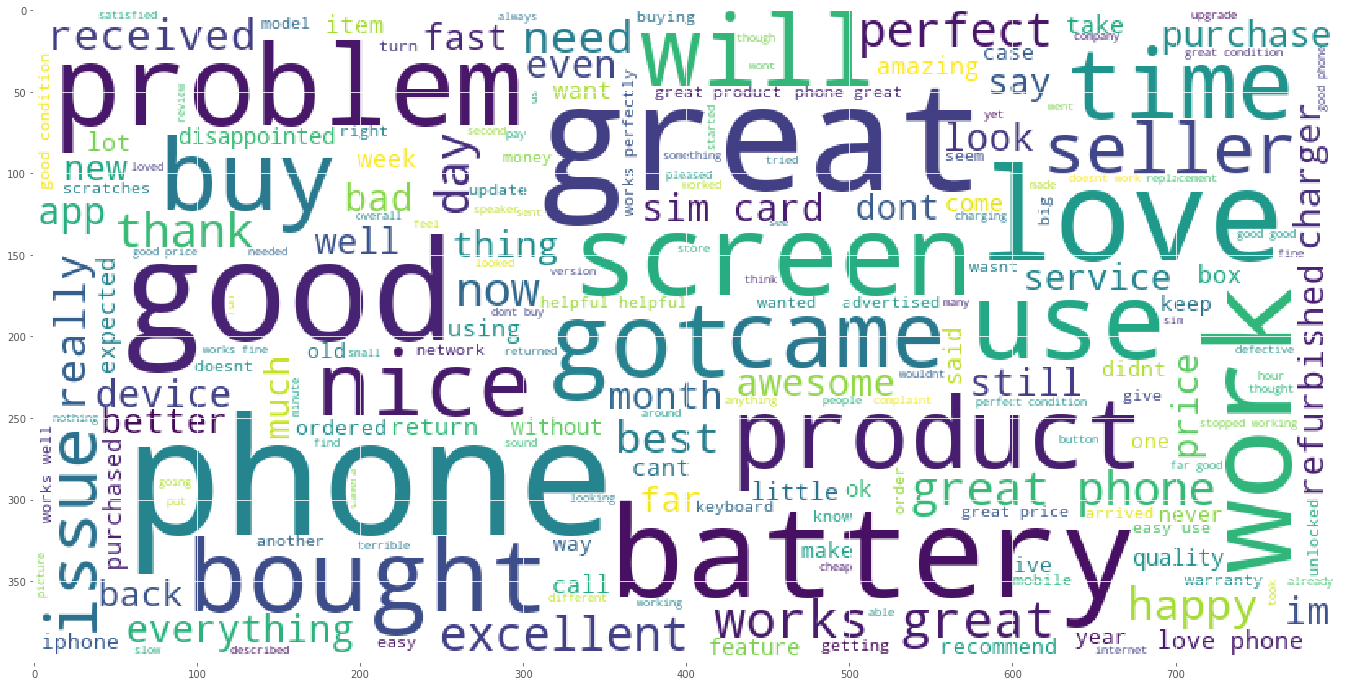

In [20]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(
    background_color='white',
    stopwords=STOPWORDS,
    max_words=200,
    max_font_size=100,
    random_state=11,
    width=800,
    height=400,
    )
wordcloud.generate(TEXT)

plt.figure(figsize=(24,12))
plt.imshow(wordcloud)

# Word Frequency Plots

In [21]:
from collections import defaultdict
from plotly import tools

df5 = df.loc[df["Stars"]==5,'Text']
df4 = df.loc[df["Stars"]==4,'Text']
df3 = df.loc[df["Stars"]==3,'Text']
df2 = df.loc[df["Stars"]==2,'Text']
df1 = df.loc[df["Stars"]==1,'Text']

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## 5 Starred Texts ##
freq_dict = defaultdict(int)
for sent in df5:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')

## 3 Starred Texts ##
freq_dict = defaultdict(int)
for sent in df3:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## 1 Starred Texts ##
freq_dict = defaultdict(int)
for sent in df1:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04,
                          subplot_titles=["5 Starred: Word Frequency",
                                          "3 Starred: Word Frequency", 
                                          "1 Starred: Word Frequency"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

In [22]:
freq_dict = defaultdict(int)
for sent in df5:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in df1:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["5 Starred: Word Bigram Frequency", 
                                          "1 Starred: Word Bigram Frequency"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

In [23]:
del TEXT,df5,df4,df3,df2,df1
gc.collect()

59835

## Save the Clean Data

In [24]:
df[['Text','Stars']].to_csv('cleaned_amazon_yuge.csv',index=False)

# Part 2: Algorithm Training

In [25]:
# Load the Data
df = pd.read_csv('cleaned_amazon_yuge.csv')
df = df.sample(frac=1.0, random_state=13).reset_index(drop=True)

X, test_X, y, test_y = train_test_split(df['Text'], df['Stars'], test_size=0.2, random_state=10, shuffle=True)

## Vectorization

### TfidfVectorizer

In [26]:
tfidf = TfidfVectorizer(token_pattern=r'\w{1,}',
                        ngram_range=(1, 3),
                        max_df=0.5,
                        min_df=3,
                        max_features=100000,
                        strip_accents='unicode'
                        #decode_error='ignore',
                       )

tfidf.fit(X)
X_tf = tfidf.transform(X)
test_X_tf = tfidf.transform(test_X)

### CountVectorizer

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(ngram_range=(1, 3),
                            max_df=0.5,
                            analyzer='word',
                            token_pattern = r'\w{1,}',
                       max_features=100000)
count.fit(X)
X_cv = count.transform(X)
test_X_cv = count.transform(test_X)

## Model Building

In [28]:
# Training on the standard data.
logr = LogisticRegression(solver='sag',multi_class="multinomial",n_jobs=-1)
a = simple_eval(logr, X_tf, y, test_X_tf)

              precision    recall  f1-score   support

      1 Star       0.70      0.89      0.79      7480
     2 Stars       0.28      0.05      0.08      2132
     3 Stars       0.39      0.20      0.26      2474
     4 Stars       0.46      0.21      0.29      4667
     5 Stars       0.80      0.95      0.87     19142

    accuracy                           0.74     35895
   macro avg       0.53      0.46      0.46     35895
weighted avg       0.68      0.74      0.69     35895

F1_micro/Acc : 73.54% 
Log Loss: 0.72


In [29]:
logr = LogisticRegression(solver='sag',multi_class="multinomial",n_jobs=-1)
a = simple_eval(logr, X_cv, y, test_X_cv)

              precision    recall  f1-score   support

      1 Star       0.73      0.83      0.78      7480
     2 Stars       0.26      0.12      0.17      2132
     3 Stars       0.34      0.24      0.28      2474
     4 Stars       0.41      0.24      0.30      4667
     5 Stars       0.81      0.93      0.86     19142

    accuracy                           0.72     35895
   macro avg       0.51      0.47      0.48     35895
weighted avg       0.67      0.72      0.69     35895

F1_micro/Acc : 72.07% 
Log Loss: 0.85


In [30]:
del X_cv, test_X_cv

In [31]:
"""
Assigning higher class weights causes the model to be more punishing when false predictions occur. 
There is a trade off between majority and minority class scores, when minority (2,3,4) recall values get higher, 
  majority (1 and 5) recall values get lower which causes the model accuracy to be lower. 
Trying out different weights didn't help as well.
"""
class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
class_weights = {clss+1: weight for clss, weight in enumerate(class_weights)}
print(class_weights)

# Training on the standard data with class weights.
logr = LogisticRegression(solver='sag',multi_class="multinomial",class_weight=class_weights,n_jobs=-1)
a = simple_eval(logr, X_tf, y, test_X_tf)

{1: 0.9533598937583001, 2: 3.4534215273601925, 3: 2.9280309982665442, 4: 1.5269981387928742, 5: 0.3752198512982007}
              precision    recall  f1-score   support

      1 Star       0.75      0.73      0.74      7480
     2 Stars       0.23      0.31      0.26      2132
     3 Stars       0.28      0.38      0.32      2474
     4 Stars       0.33      0.45      0.38      4667
     5 Stars       0.90      0.75      0.81     19142

    accuracy                           0.65     35895
   macro avg       0.50      0.52      0.50     35895
weighted avg       0.71      0.65      0.67     35895

F1_micro/Acc : 65.26% 
Log Loss: 0.87


### Over-Sampling Using SMOTE, SVMSMOTE, ADASYN
SMOTE and other over-sampling methods didn't help as well. Pretty much resulted the same as before, recall trade-off between classes.
The major issue is the scarcity of information in the data. Over sampling doesn't increase the overall information.### Over-Sampling Using SMOTE, ADASYN,RandomOverSampler

In [32]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
# Standard Data Class Distribution
print("Class Distribution for Standard Data:\n",Counter(y))

# Apply SMOTE on Tfidf vector
smote = SMOTE(sampling_strategy='auto', random_state=10,n_jobs=-1)
X_smote, y_smote = smote.fit_sample(X_tf,y)
print("Class Distribution for SMOTE:\n",Counter(y_smote))

ada = ADASYN(sampling_strategy='not majority', random_state=10,n_jobs=-1)
X_ada, y_ada = ada.fit_sample(X_tf,y)
print("Class Distribution for ADASYN:\n",Counter(y_ada))

rsamp = RandomOverSampler(random_state=10)
X_ra, y_ra = rsamp.fit_sample(X_tf,y)
print("Class Distribution for RandomOverSampler:\n",Counter(y_ra))

Class Distribution for Standard Data:
 Counter({5: 76529, 1: 30120, 4: 18805, 3: 9807, 2: 8315})
Class Distribution for SMOTE:
 Counter({1: 76529, 3: 76529, 4: 76529, 5: 76529, 2: 76529})
Class Distribution for ADASYN:
 Counter({4: 80978, 1: 80454, 2: 78688, 5: 76529, 3: 73845})
Class Distribution for RandomOverSampler:
 Counter({1: 76529, 3: 76529, 4: 76529, 5: 76529, 2: 76529})


In [33]:
# Apply SMOTE on Tfidf vector
logr = LogisticRegression(solver='sag',multi_class="multinomial",n_jobs=-1)
a = simple_eval(logr, X_smote, y_smote, test_X_tf)

              precision    recall  f1-score   support

      1 Star       0.74      0.76      0.75      7480
     2 Stars       0.21      0.24      0.22      2132
     3 Stars       0.28      0.34      0.31      2474
     4 Stars       0.33      0.37      0.35      4667
     5 Stars       0.87      0.78      0.82     19142

    accuracy                           0.66     35895
   macro avg       0.48      0.50      0.49     35895
weighted avg       0.69      0.66      0.67     35895

F1_micro/Acc : 66.32% 
Log Loss: 0.85


In [34]:
# Apply ADASYN on Tfidf vector
logr = LogisticRegression(solver='sag',multi_class="multinomial",n_jobs=-1)
a = simple_eval(logr, X_ada, y_ada, test_X_tf)

              precision    recall  f1-score   support

      1 Star       0.74      0.77      0.75      7480
     2 Stars       0.21      0.25      0.23      2132
     3 Stars       0.29      0.33      0.30      2474
     4 Stars       0.32      0.38      0.35      4667
     5 Stars       0.87      0.78      0.82     19142

    accuracy                           0.66     35895
   macro avg       0.49      0.50      0.49     35895
weighted avg       0.69      0.66      0.68     35895

F1_micro/Acc : 66.47% 
Log Loss: 0.85


In [35]:
# Apply RandomOverSampler on Tfidf vector
logr = LogisticRegression(solver='sag',multi_class="multinomial",n_jobs=-1)
a = simple_eval(logr, X_ra, y_ra, test_X_tf)

              precision    recall  f1-score   support

      1 Star       0.75      0.72      0.74      7480
     2 Stars       0.21      0.27      0.24      2132
     3 Stars       0.27      0.35      0.30      2474
     4 Stars       0.33      0.43      0.37      4667
     5 Stars       0.88      0.77      0.82     19142

    accuracy                           0.66     35895
   macro avg       0.49      0.51      0.49     35895
weighted avg       0.70      0.66      0.67     35895

F1_micro/Acc : 65.55% 
Log Loss: 0.86


In [36]:
del X_smote, y_smote, X_ada, y_ada, X_ra, y_ra
gc.collect()

309

### Under-sampling Using NearMiss, RandomUnderSampler

In [37]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler

nm1 = NearMiss(version=1,random_state=10,n_jobs=-1)
nm2 = NearMiss(version=2,random_state=10,n_jobs=-1)
nm3 = NearMiss(version=3,random_state=10,n_jobs=-1)
rus = RandomUnderSampler(random_state=10)

In [38]:
X_nm1, y_nm1 = nm1.fit_sample(X_tf,y)
print("Class Distribution for Nearmiss Version 1:\n",Counter(y_nm1))

logr = LogisticRegression(solver='sag',multi_class="multinomial",class_weight=class_weights,n_jobs=-1)
a= simple_eval(logr,X_nm1, y_nm1, test_X_tf)
del X_nm1, y_nm1

Class Distribution for Nearmiss Version 1:
 Counter({1: 8315, 2: 8315, 3: 8315, 4: 8315, 5: 8315})
              precision    recall  f1-score   support

      1 Star       0.84      0.26      0.40      7480
     2 Stars       0.16      0.63      0.25      2132
     3 Stars       0.16      0.48      0.23      2474
     4 Stars       0.16      0.54      0.24      4667
     5 Stars       0.93      0.05      0.10     19142

    accuracy                           0.22     35895
   macro avg       0.45      0.39      0.24     35895
weighted avg       0.71      0.22      0.20     35895

F1_micro/Acc : 22.21% 
Log Loss: 2.16


In [39]:
X_nm2, y_nm2 = nm2.fit_sample(X_tf,y)
print("Class Distribution for Nearmiss Version 2:\n",Counter(y_nm2))

logr = LogisticRegression(solver='sag',multi_class="multinomial",class_weight=class_weights,n_jobs=-1)
a = simple_eval(logr,X_nm2, y_nm2, test_X_tf)
del X_nm2, y_nm2

Class Distribution for Nearmiss Version 2:
 Counter({1: 8315, 2: 8315, 3: 8315, 4: 8315, 5: 8315})
              precision    recall  f1-score   support

      1 Star       0.87      0.29      0.43      7480
     2 Stars       0.14      0.61      0.23      2132
     3 Stars       0.17      0.48      0.26      2474
     4 Stars       0.20      0.49      0.28      4667
     5 Stars       0.95      0.29      0.45     19142

    accuracy                           0.35     35895
   macro avg       0.47      0.43      0.33     35895
weighted avg       0.73      0.35      0.40     35895

F1_micro/Acc : 35.03% 
Log Loss: 1.49


In [40]:
X_nm3, y_nm3 = nm3.fit_sample(X_tf, y)
print("Class Distribution for Nearmiss Version 3:\n",Counter(y_nm3))

logr = LogisticRegression(solver='sag',multi_class="multinomial",class_weight=class_weights,n_jobs=-1)
a = simple_eval(logr,X_nm3, y_nm3, test_X_tf)
del X_nm3, y_nm3

Class Distribution for Nearmiss Version 3:
 Counter({2: 8315, 1: 1519, 5: 784, 3: 595, 4: 503})
              precision    recall  f1-score   support

      1 Star       0.87      0.01      0.01      7480
     2 Stars       0.06      0.99      0.12      2132
     3 Stars       0.04      0.01      0.02      2474
     4 Stars       0.16      0.00      0.01      4667
     5 Stars       0.87      0.01      0.03     19142

    accuracy                           0.07     35895
   macro avg       0.40      0.21      0.04     35895
weighted avg       0.67      0.07      0.03     35895

F1_micro/Acc : 6.90% 
Log Loss: 3.90


In [41]:
X_rus, y_rus = rus.fit_sample(X_tf,y)
print("Class Distribution for RandomUnderSampler:\n",Counter(y_rus))

logr = LogisticRegression(solver='sag',multi_class="multinomial",class_weight=class_weights,n_jobs=-1)
a = simple_eval(logr,X_rus, y_rus, test_X_tf)
del X_rus, y_rus

Class Distribution for RandomUnderSampler:
 Counter({1: 8315, 2: 8315, 3: 8315, 4: 8315, 5: 8315})
              precision    recall  f1-score   support

      1 Star       0.87      0.29      0.43      7480
     2 Stars       0.16      0.62      0.25      2132
     3 Stars       0.18      0.49      0.26      2474
     4 Stars       0.18      0.54      0.27      4667
     5 Stars       0.96      0.21      0.34     19142

    accuracy                           0.31     35895
   macro avg       0.47      0.43      0.31     35895
weighted avg       0.74      0.31      0.34     35895

F1_micro/Acc : 31.15% 
Log Loss: 1.51


#### Under-Sampling Results
RandomUnderSampler and Nearmiss version-2 yields best results among other under sampling methods, but fails to pass the success of the first model that trained on the original data mainly due to the scarcity of training data and inability to distinguish between similar classes. ~40% recall ~25% precision on 2-3-4 Star classes indicates the model is trying hard to find them, but fails.

This model can be used in stacking and blending, because of the relative success in finding minority classes.

In [42]:
gc.collect()

140

### LogisticRegression

In [43]:
# Training on the standard data with class weights.
logr = LogisticRegression(solver='sag',multi_class="multinomial" ,n_jobs=-1)
logr, logr_probs = simple_eval(logr, X_tf, y, test_X_tf)

              precision    recall  f1-score   support

      1 Star       0.70      0.89      0.79      7480
     2 Stars       0.28      0.05      0.08      2132
     3 Stars       0.39      0.20      0.26      2474
     4 Stars       0.46      0.21      0.29      4667
     5 Stars       0.80      0.95      0.87     19142

    accuracy                           0.74     35895
   macro avg       0.53      0.46      0.46     35895
weighted avg       0.68      0.74      0.69     35895

F1_micro/Acc : 73.54% 
Log Loss: 0.72


Image shows the top Tfidf features and their weights measured by the first logistic regression model, which trained on the original data and had no class weights assigned.

At first glance, we can see that there is no leakage left in the data. Some review texts contained target information, such as "gave two stars"; also phone brand and model information could had a similar affect.

It's hard to distinguish close classes from one another. You can see common words in different classes, such as "perfect","awesome","love", etc. are common in 4th and 5th classes. 1 and 2 starred reviews share features like "defective", "not", "not a good", "bad", etc.


In [44]:
eli5.show_weights(logr, vec=tfidf, top=40)

Graph shows high bias and high variance, the model needs much more high quality data to improve the results

There are few garbage data in the reviews (spam, misleading review, etc.) which decreases the overall quality of the data a bit.


<module 'matplotlib.pyplot' from 'G:\\Users\\dogus\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 432x288 with 0 Axes>

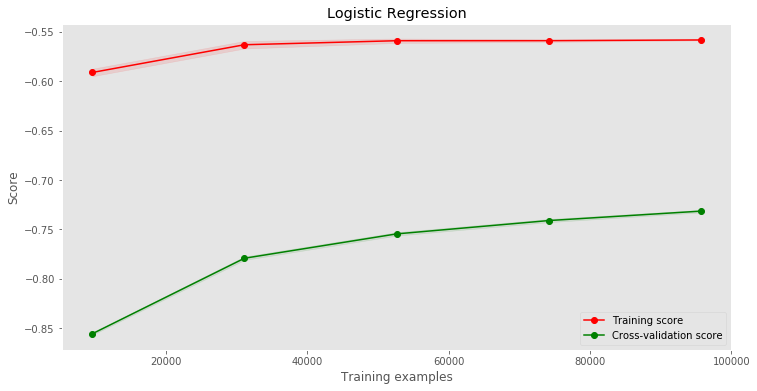

In [45]:
plot_learning_curve(logr,'Logistic Regression', scoring='neg_log_loss', X=X_tf, y=y, n_jobs=4)

### Stochastic Gradient Descent

In [46]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-5, n_jobs=-1)
#sgd, sgd_preds = model_eval(sgd)
sgd, sgd_probs = simple_eval(sgd, X_tf, y, test_X_tf)

              precision    recall  f1-score   support

      1 Star       0.71      0.85      0.78      7480
     2 Stars       0.25      0.09      0.13      2132
     3 Stars       0.34      0.22      0.26      2474
     4 Stars       0.42      0.22      0.28      4667
     5 Stars       0.81      0.94      0.87     19142

    accuracy                           0.72     35895
   macro avg       0.50      0.46      0.46     35895
weighted avg       0.67      0.72      0.69     35895

F1_micro/Acc : 72.45% 
Log Loss: 2.27


<module 'matplotlib.pyplot' from 'G:\\Users\\dogus\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 432x288 with 0 Axes>

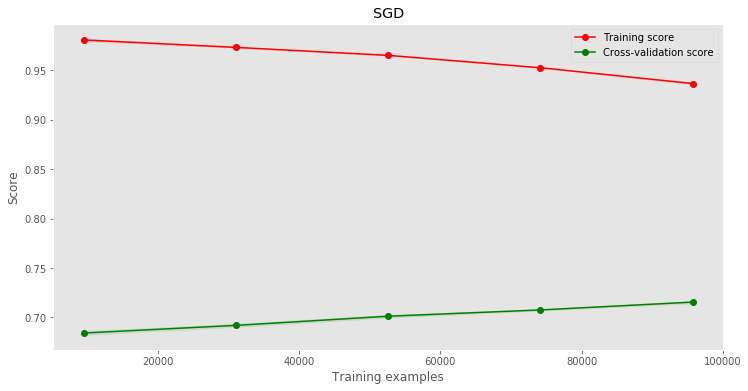

In [47]:
plot_learning_curve(sgd,'SGD', X=X_tf, y=y, scoring='accuracy', n_jobs=4)

In [48]:
eli5.show_weights(sgd, vec=tfidf, top=40)

### Multinomial Naive Bayes

In [49]:
MNB = MultinomialNB()
#MNB, MNB_preds = model_eval(MNB)
MNB, MNB_probs = simple_eval(MNB, X_tf, y, test_X_tf)

              precision    recall  f1-score   support

      1 Star       0.65      0.91      0.76      7480
     2 Stars       0.00      0.00      0.00      2132
     3 Stars       0.53      0.01      0.02      2474
     4 Stars       0.45      0.10      0.17      4667
     5 Stars       0.76      0.97      0.85     19142

    accuracy                           0.72     35895
   macro avg       0.48      0.40      0.36     35895
weighted avg       0.64      0.72      0.64     35895

F1_micro/Acc : 72.11% 
Log Loss: 0.84


### RandomForestClassifier

In [50]:
%%time
tree = RandomForestClassifier(max_depth=300, n_estimators=50, verbose=1, n_jobs=-1)
#tree , tree_preds = model_eval(tree, k=3)
tree , tree_probs = simple_eval(tree,X_tf, y, test_X_tf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.8s finished


              precision    recall  f1-score   support

      1 Star       0.65      0.85      0.74      7480
     2 Stars       0.32      0.01      0.02      2132
     3 Stars       0.33      0.02      0.04      2474
     4 Stars       0.44      0.05      0.09      4667
     5 Stars       0.73      0.97      0.84     19142

    accuracy                           0.70     35895
   macro avg       0.49      0.38      0.34     35895
weighted avg       0.63      0.70      0.61     35895

F1_micro/Acc : 70.32% 
Log Loss: 0.90
Wall time: 8min 11s


In [51]:
std = np.std([ree.feature_importances_ for ree in tree.estimators_], axis=0).astype(np.float32)
imps = pd.DataFrame({
    'Features':tfidf.get_feature_names(),
    'Importances':tree.feature_importances_.astype(np.float32),
    'Stds':std
    }
            ).sort_values(by='Importances', ascending=False).reset_index(drop=True)
# Save Important Features
imps.to_csv('important_features.csv',index=False)

trace = go.Bar(x=imps.Features[:20],
                y=imps.Importances[:20],
                marker=dict(color='red'),
                error_y = dict(visible=True, arrayminus=imps.Stds[:20]),
                opacity=0.5
               )
layout = go.Layout(title="RandomForest Feature Importances")
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

### Lightgbm

In [52]:
%%time
model = LGBMClassifier(objective='softmax')
#lgb_model, lgb_preds = model_eval(model)
lgb_model, lgb_probs = simple_eval(model,X_tf,y,test_X_tf)

              precision    recall  f1-score   support

      1 Star       0.67      0.84      0.75      7480
     2 Stars       0.31      0.03      0.06      2132
     3 Stars       0.38      0.13      0.20      2474
     4 Stars       0.44      0.18      0.26      4667
     5 Stars       0.77      0.95      0.85     19142

    accuracy                           0.71     35895
   macro avg       0.51      0.43      0.42     35895
weighted avg       0.65      0.71      0.66     35895

F1_micro/Acc : 71.49% 
Log Loss: 0.78
Wall time: 4min 22s


In [53]:
del X_tf, test_X_tf

# Neural Networks

In [55]:
df = pd.read_csv('cleaned_amazon_yuge.csv')
df = df.dropna(axis=0).sample(frac=1, random_state=13).reset_index(drop=True)
X = df['Text']
y = df['Stars']

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit(y.values.reshape(-1,1))
max_len=200
tokenizer = text.Tokenizer(num_words=max_len)
tokenizer.fit_on_texts(X)

#print(tokenizer.word_counts)
#print(tokenizer.document_count)
#print(tokenizer.word_index)
#print(tokenizer.word_docs)

X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen = 200).astype(np.int32)
y = ohe.transform(y.values.reshape(-1,1)).astype(np.uint8)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=10)
del df, X, y
gc.collect()

17

In [56]:
f = open('glove.840B.300d/glove.840B.300d.txt', encoding='utf-8')
embeddings_index={}
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

W0915 01:57:48.812472 10224 deprecation_wrapper.py:119] From G:\Users\dogus\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0915 01:57:49.559009 10224 deprecation_wrapper.py:119] From G:\Users\dogus\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 01:57:49.722031 10224 deprecation_wrapper.py:119] From G:\Users\dogus\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0915 01:57:49.866246 10224 deprecation_wrapper.py:119] From G:\Users\dogus\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0915 01:57:49.866246 10224 deprecation_wrapper.py:119] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          12153900  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 300)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 200, 300)          540900    
_________________________________________________________________
gru_2 (GRU)                  (None, 300)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               154112    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total para

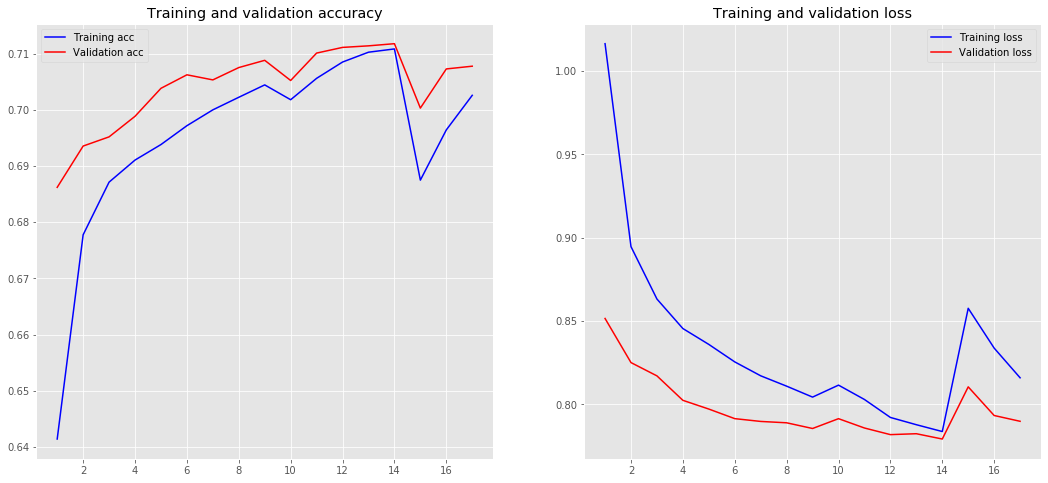

In [57]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss',patience=3, min_delta=0, verbose=0, mode='auto')

nlabels=5

model = Sequential()
model.add(layers.Embedding(len(word_index)+1,
                           300,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False))
model.add(layers.SpatialDropout1D(0.3))
model.add(layers.GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(layers.GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.8))

model.add(layers.Dense(nlabels, activation='sigmoid')) #'sigmoid'
model.compile(loss='categorical_crossentropy',
                optimizer='adam', #'adam',# optimizer.SGD(lr=1e-3)
                metrics=['acc'])
model.summary()

batch=512
epoch=30

history = model.fit(xtrain, ytrain,
                    validation_split=0.2,
                    epochs=epoch,
                    batch_size=batch,
                   verbose=1,
                   callbacks=[earlystop])
score, acc = model.evaluate(xtest, ytest,
                            batch_size=batch)
model.save('gru_model.h5')
#model.save_weights('gru_weights.h5')

NN_preds = model.predict_proba(xtest,batch_size=batch)
print(confusion_matrix(np.argmax(ytest, axis=1)+1, np.argmax(NN_preds, axis=1)+1))
print(classification_report(np.argmax(ytest, axis=1)+1, np.argmax(NN_preds, axis=1)+1))
print('Log Loss: {:.2f}'.format(log_loss(ytest, NN_preds)))
plot_history(history)